In [1]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


In [2]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme ='gruvboxd',context='notebook',grid=False,ticks=True)

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

Automatically created module for IPython interactive environment


<Figure size 1512x936 with 0 Axes>

In [3]:
# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'],
                        xi=params['xi'],
                        min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatch\nKMeans', two_means),
    ('Affinity\nPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('Spectral\nClustering', spectral),
    ('Ward', ward),
    ('Agglomerative\nClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('OPTICS', optics),
    ('BIRCH', birch),
    ('Gaussian\nMixture', gmm)
)

C:\Users\R3M0\anaconda3\envs\38tfgpu\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\R3M0\anaconda3\envs\38tfgpu\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


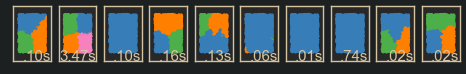

In [4]:
for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

In [5]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme ='gruvboxd',context='notebook',grid=False,ticks=True)

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
#     plt.figure()
#     plt.scatter(X[:,0],X[:,1])

Automatically created module for IPython interactive environment


<Figure size 1512x936 with 0 Axes>

In [6]:
# colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426' if x == 2 else '#67c614',P))
# plt.scatter(X[:,0], X[:,1], c=colors, marker="o", picker=True)
def kmeans(X,n_clus):
    N = X.shape[1]
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.scatter(X[0,:],X[1,:])
    idx = np.random.randint(0,N,n_clus);
    # centers of clusters
#     center = np.array([[X[0,idx[0]],X[0,idx[1]],X[0,idx[2]],X[0,idx[3]]],
#                        [X[1,idx[0]],X[1,idx[1]],X[1,idx[2]],X[1,idx[3]]]]);
    center = np.array([[X[0,idx[0]]],[X[1,idx[0]]]]);
    for i in np.arange(1,n_clus):
        center = np.append(center,np.array([[X[0,idx[i]]],[X[1,idx[i]]]]),axis=1)
    for iter in range(10):
        clusters = {"1" : [[],[]]};
        for i in np.arange(1,n_clus):
            clusters[str(i+1)] = [[],[]];
        # distance array
        dist = np.empty((0,N),int);
        # looping over clusters
        for i in range(n_clus):
            # storing distances
            dist=np.append(dist,[(X[0,:]-center[0,i])**2+(X[1,:]-center[1,i])**2],axis=0);
        # finding min distance
        min_dist = np.amin(dist,axis=0);
        # index of cluster with min distance
        min_idx = np.argmin(dist,axis=0);
        # looping and storing points to clusters
        for i in range(len(min_idx)):
            clusters[str(min_idx[i]+1)] = np.append(clusters[str(min_idx[i]+1)],np.array([[X[0,i]],[X[1,i]]]),axis=1);
        # updating centers of clusters
        for i in range(n_clus):
            center[:,i] = np.mean(clusters[str(i+1)],axis=1);
#     plt.figure(figsize=(10,6));
    plt.subplot(1,2,2)
    mrkr = ['*','o','+','x'];
    for i in range(n_clus):
        plt.scatter(clusters[str(i+1)][0,:],clusters[str(i+1)][1,:],marker=mrkr[i]);
    plt.scatter(center[0,:],center[1,:],marker='x',color='white',s=150);

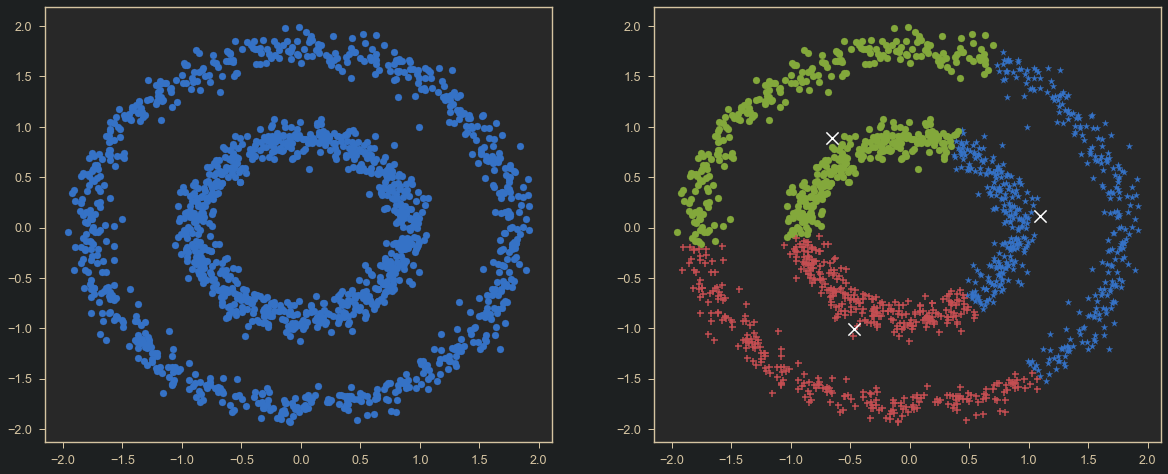

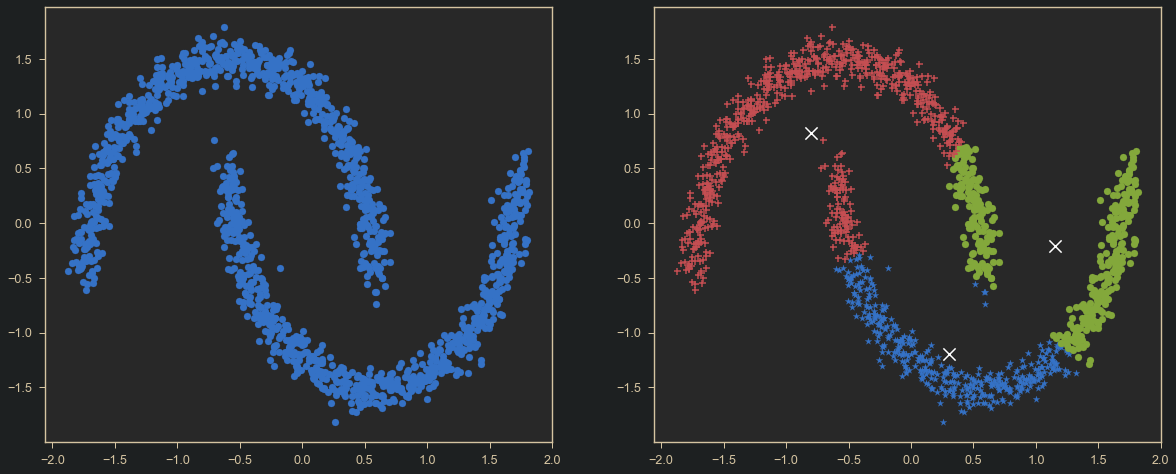

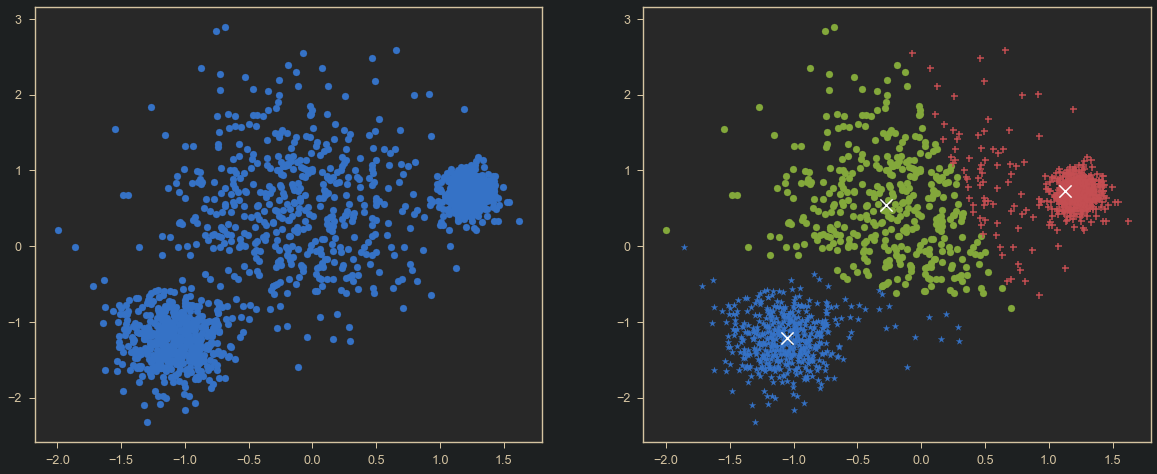

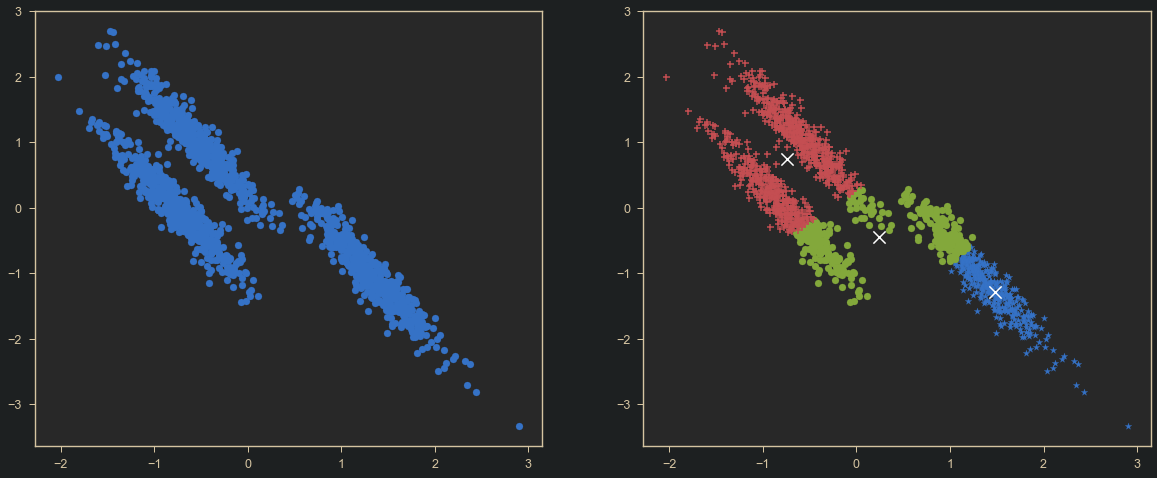

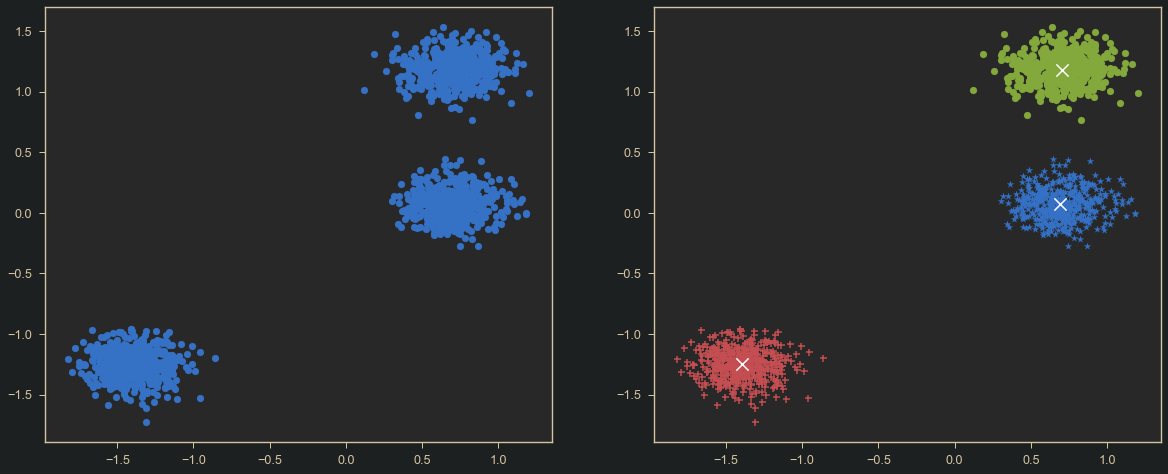

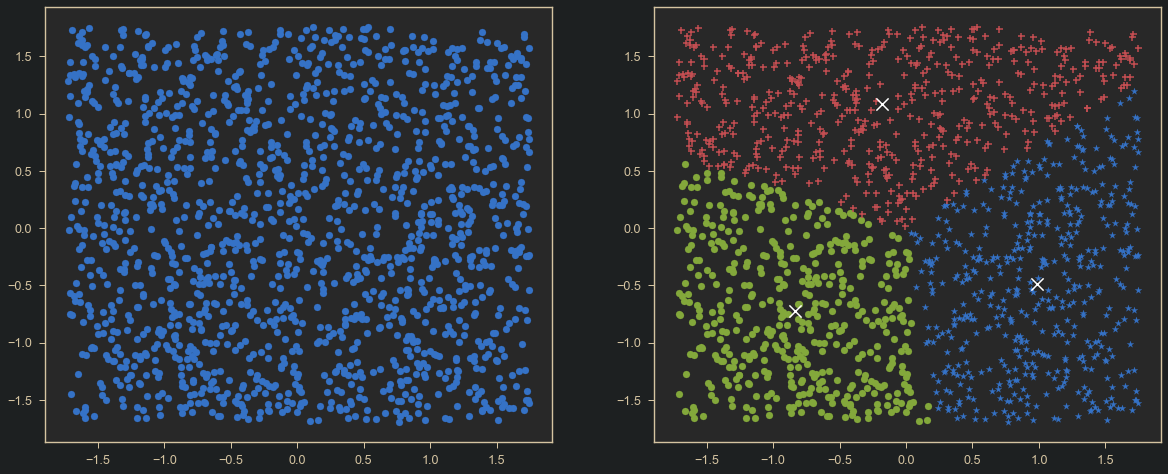

In [7]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    kmeans(X.T,3)

In [8]:
def initialization(data,K):
    # declaring a random index array of length K between 0 and no of pts in data
    X=data;n_clus=K;
    N = X.shape[1];
    idx = np.random.randint(0,N,n_clus);
    center = np.array([[X[0,idx[0]]],[X[1,idx[0]]]]);
    for i in np.arange(1,n_clus):
        center = np.append(center,np.array([[X[0,idx[i]]],[X[1,idx[i]]]]),axis=1)
    for iter in range(10):
        clusters = {"1" : [[],[]]};
        for i in np.arange(1,n_clus):
            clusters[str(i+1)] = [[],[]];
        # distance array
        dist = np.empty((0,N),int);
        # looping over clusters
        for i in range(n_clus):
            # storing distances
            dist=np.append(dist,[(X[0,:]-center[0,i])**2+(X[1,:]-center[1,i])**2],axis=0);
        # finding min distance
        min_dist = np.amin(dist,axis=0);
        # index of cluster with min distance
        min_idx = np.argmin(dist,axis=0);
        # looping and storing points to clusters
        for i in range(len(min_idx)):
            clusters[str(min_idx[i]+1)] = np.append(clusters[str(min_idx[i]+1)],np.array([[X[0,i]],[X[1,i]]]),axis=1);
        # updating centers of clusters
        for i in range(n_clus):
            center[:,i] = np.mean(clusters[str(i+1)],axis=1);
    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)
    mrkr = ['*','o','+','x'];
    for i in range(n_clus):
        plt.scatter(clusters[str(i+1)][0,:],clusters[str(i+1)][1,:],marker=mrkr[i]);
    plt.scatter(center[0,:],center[1,:],marker='x',color='white',s=150);
    # dictionary of theta
    theta ={
        'means' : np.empty((0,2)),
        'cov' : np.empty((0,2,2)),
        'weights' : np.ones((1,K))/K
    }
    # looping to store means and cov
    for i in range(K):
        theta['means'] = np.append(theta['means'],[[center[0,i],center[1,i]]],axis=0); # randomly chosen K points
        theta['cov'] = np.append(theta['cov'],[[[0.15,0],[0,0.15]]],axis=0);
    return theta

# E-Step GMM
from scipy.stats import multivariate_normal

def E_Step_GMM(data,K,theta):
    p = np.empty((0,len(data[0,:])));
    responsibility = [[],[]];
    # finning prob for each point belonging to clusters
    for k in range(K):
        p = np.append(p,[multivariate_normal.pdf(data.T,mean=theta['means'][k,:],cov=theta['cov'][k,:,:])],axis=0);
    p = p.T;
    # multiplying by weight and normalising
    responsibility = (p*theta['weights'])/np.sum(p*theta['weights'],axis=1,keepdims=True);
    return responsibility

# M-STEP GMM
def M_Step_GMM(data,responsibility,theta,K):
    # decalring and updating
    Nk = np.sum(responsibility,axis=0,keepdims=True);
    N = float(data.shape[1]);
    # updating weights and means
    theta['weights'] = Nk/N;
    theta['means'] = (data@responsibility/Nk).T;
    # looping to get cov for each K
    for i in range(len(Nk)):
        theta['cov'][i,:,:] = ((responsibility[:,i].T)*(data-np.array([theta['means'][i,:]]).T))@(data.T-np.array([theta['means'][i,:]]))/Nk[0,i];
    p = np.empty((0,len(data[0,:])));
    # finding prob
    for k in range(len(Nk)):
        p = np.append(p,[multivariate_normal.pdf(data.T,theta['means'][k,:],theta['cov'][k,:,:])],axis=0);
    p = p.T;
    # finding log likelihood
    log_likelihood = np.sum(np.log(np.sum(p*theta['weights'],axis=1)))
    return theta, log_likelihood

def GMM(data,K,Itr):
    log_l=[]
#     Itr=25
    eps=10**(-14)  # for threshold
    clr=['r','g','b','y','k','m','c']
    mrk=['+','*','X','o','.','<','p']
    theta=initialization(data,K)
    for n in range(Itr):
        responsibility=E_Step_GMM(data,K,theta)
        cluster_label=np.argmax(responsibility,axis=1) #Label Points
        theta,log_likhd=M_Step_GMM(data,responsibility,theta,K)
        log_l.append(log_likhd)
        if n>2:
            if abs(log_l[n]-log_l[n-1])<eps:
                  break
#     plt.figure(figsize=(18,8))
    plt.subplot(1,2,2)
    for l in range(K):
        id=np.where(cluster_label==l)
        plt.scatter(data[0,id],data[1,id],color=clr[l],marker=mrk[l])
    Cents=theta['means']
    plt.scatter(Cents[:,0],Cents[:,1],marker='x',color='white',s=150)
#     plt.subplot(1,2,1)
#     plt.scatter(X[:,0],X[:,1])

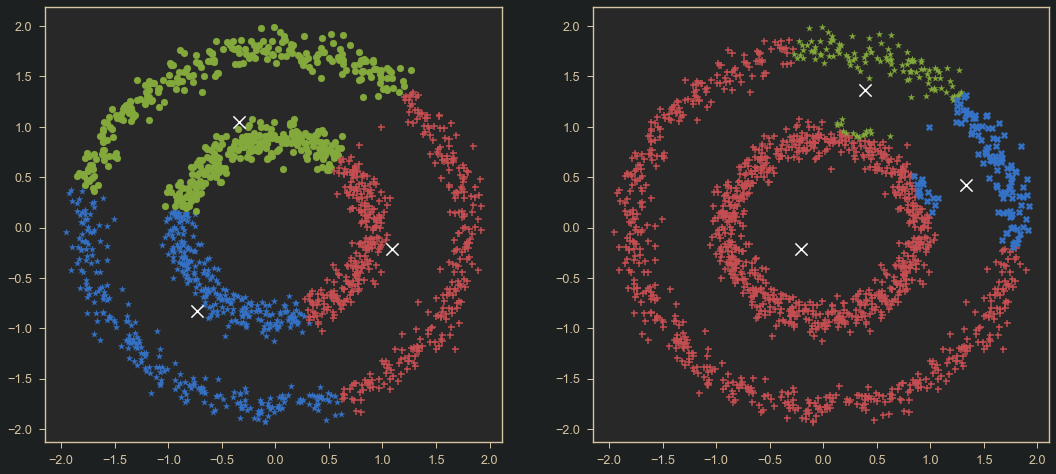

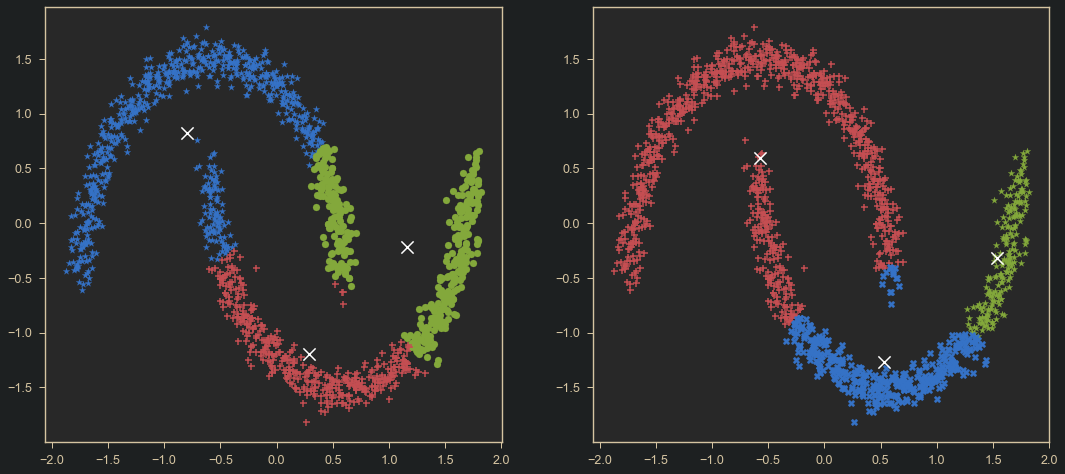

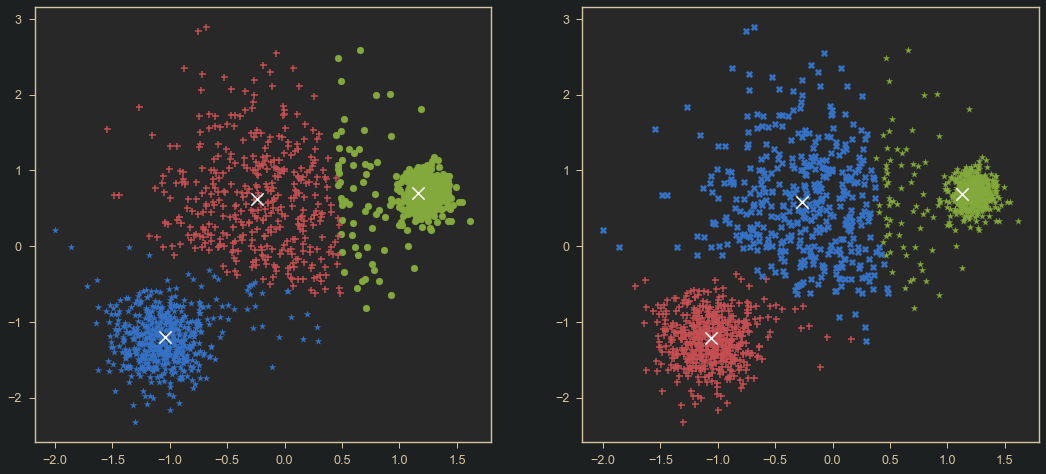

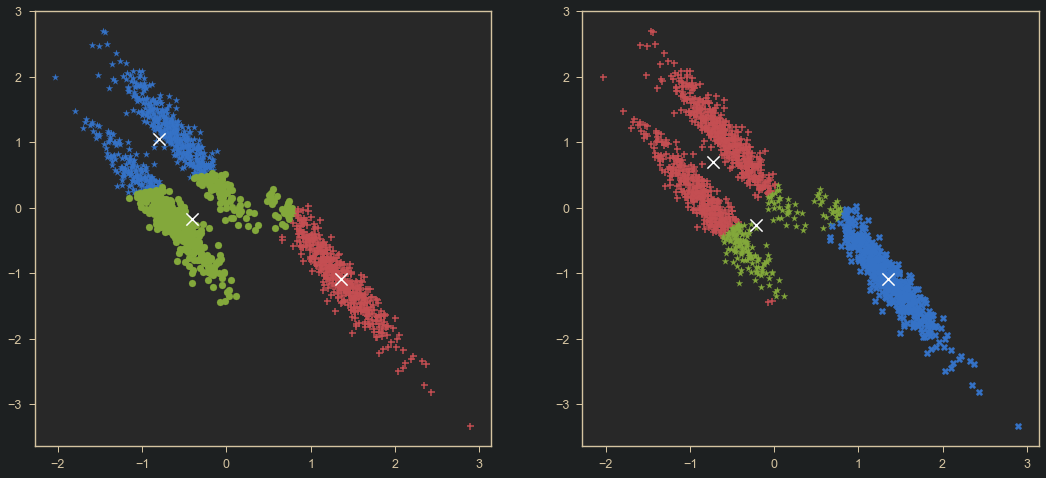

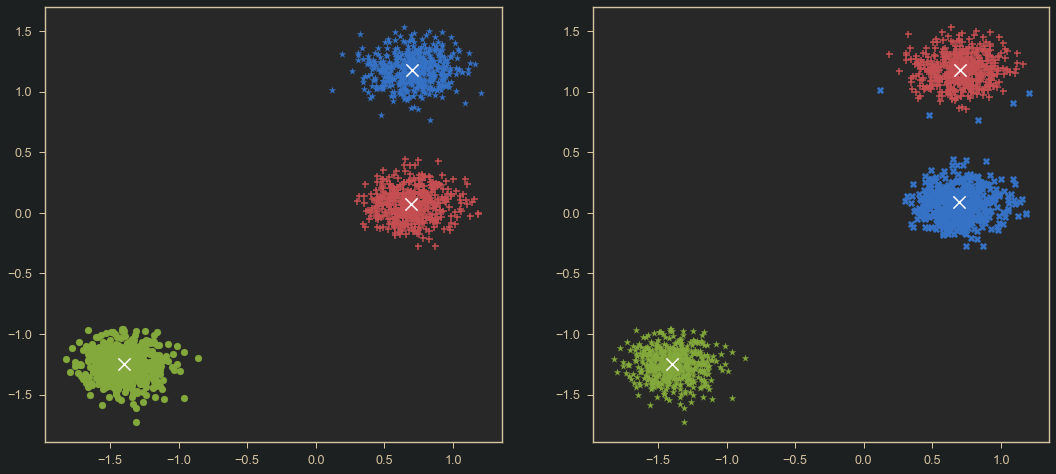

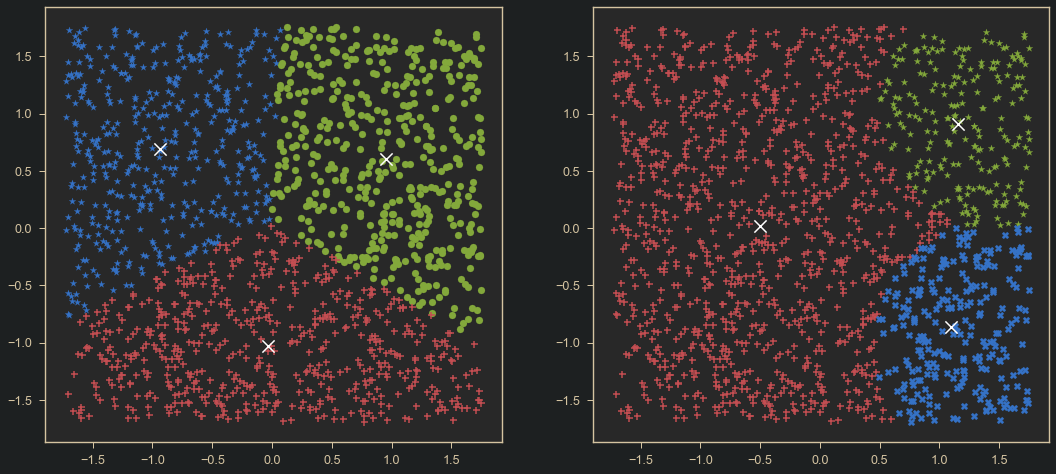

In [9]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    GMM(X.T,3,25)

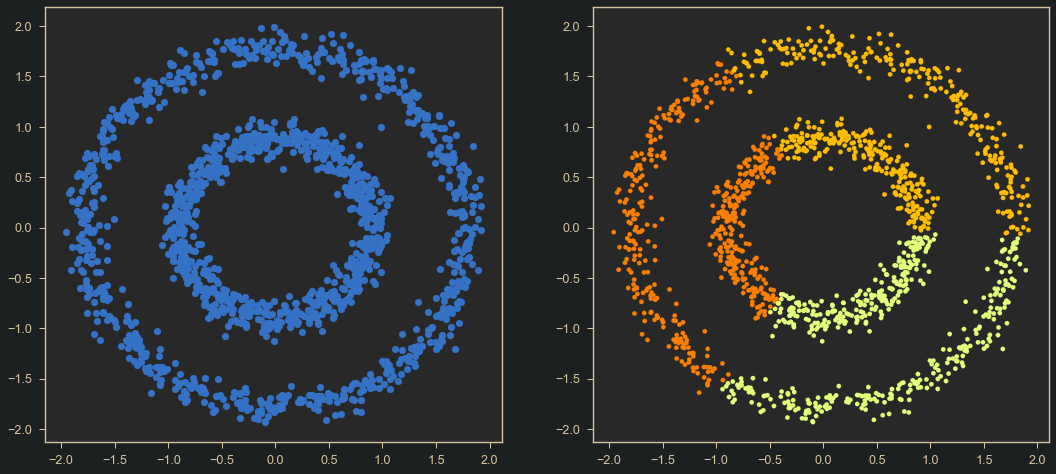

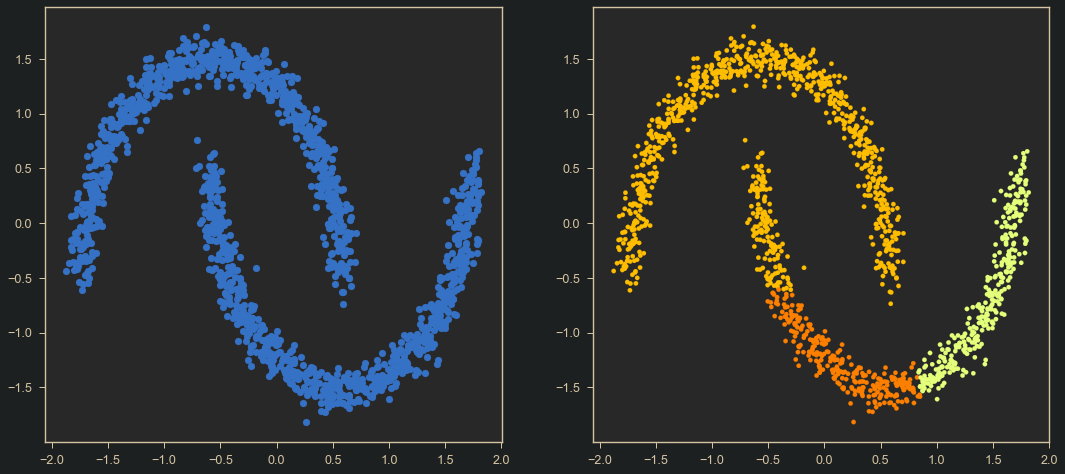

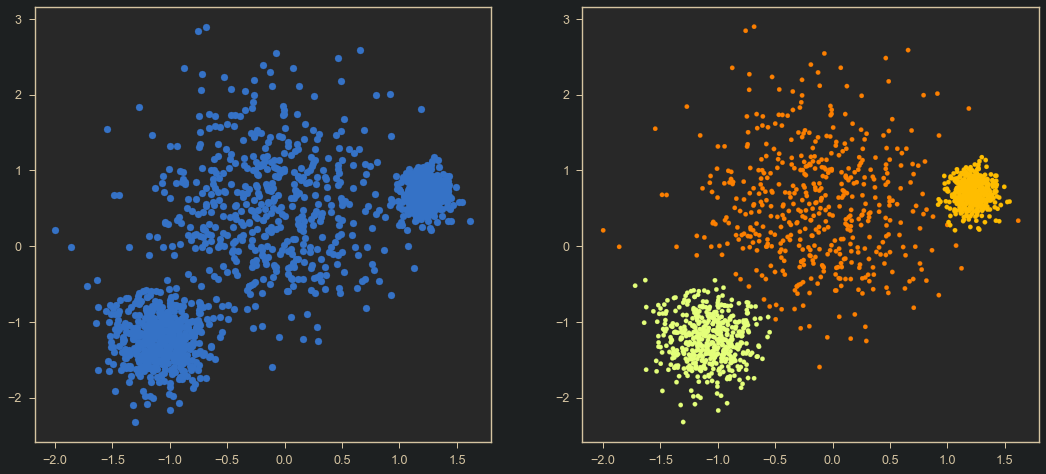

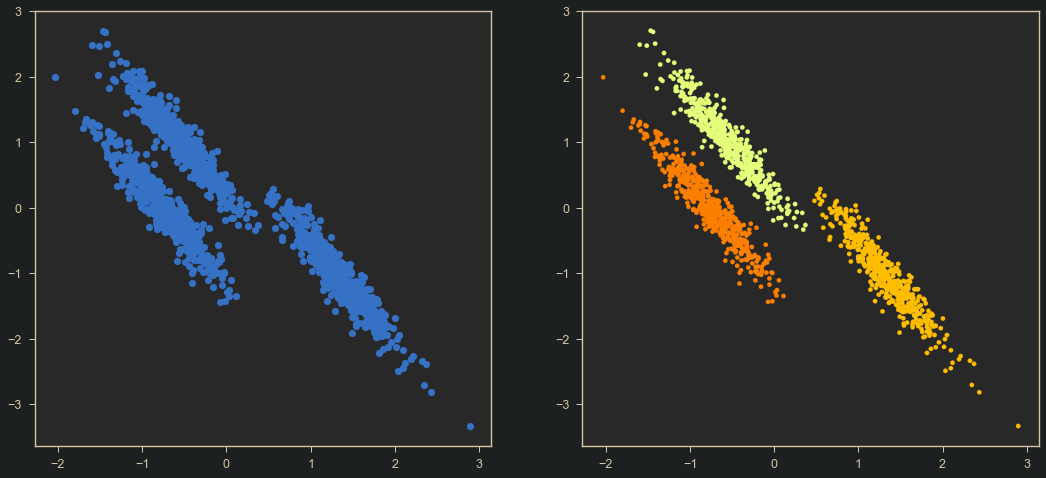

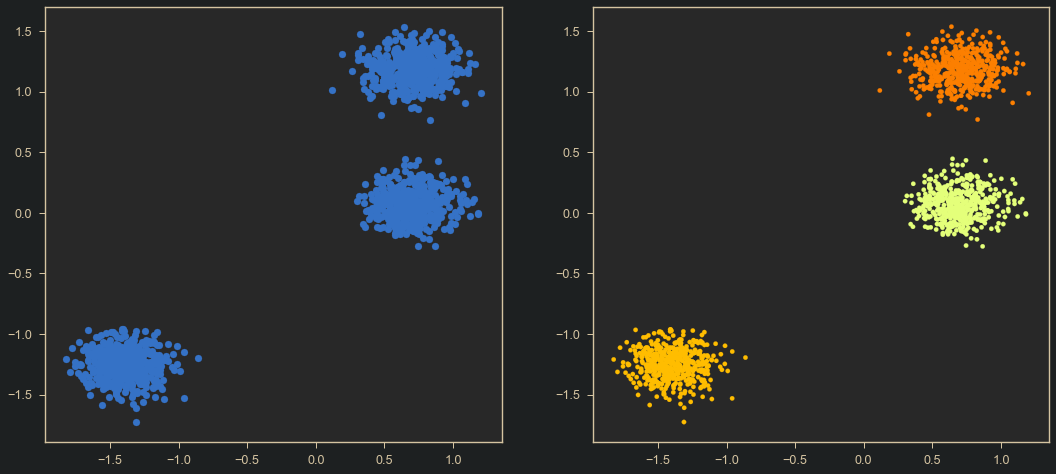

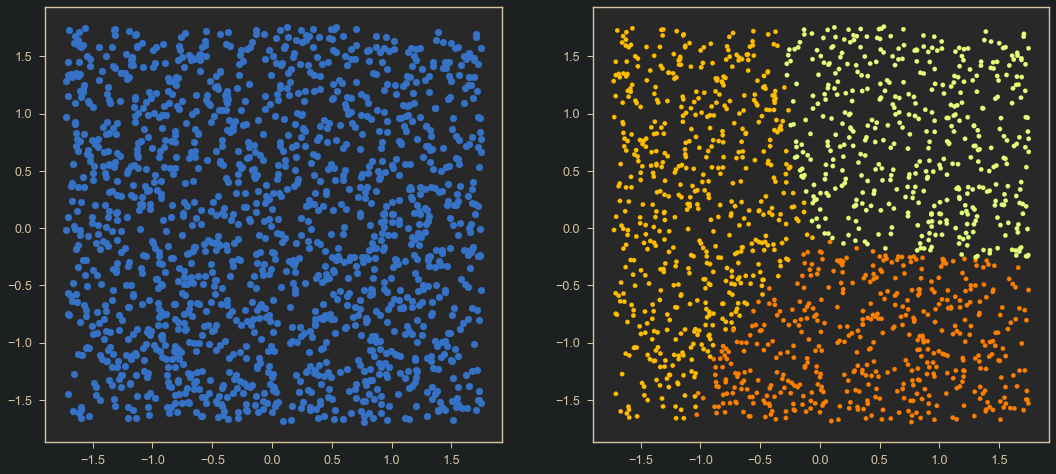

In [10]:
from sklearn.mixture import GaussianMixture
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)
    plt.scatter(X[:,0],X[:,1])
    plt.subplot(1,2,2)
    gmm = GaussianMixture(n_components=3).fit(X)
    labels = gmm.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='Wistia')